In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

np.random.seed(7)

Using TensorFlow backend.


In [2]:
# First we read in the airline passenger
fileName = "data/international-airline-passengers.csv"
#fileName = "data/wolfer-sunspot-numbers-1770-to-1.csv"

# Load the data
df = pd.read_csv(fileName, engine='python', skipfooter=3)

# Process month to be a time format
print(df.iloc[0][0])
time_column_name = 'Month'
df[time_column_name]=pd.to_datetime(df[time_column_name], format='%Y-%m-%d')
df.set_index([time_column_name], inplace=True)

# Extract the raw data, without the dates
data = df.values
data = data.astype('float32')

# Initialize the Data Scaler
scaler = MinMaxScaler()

# Now we split the data and apply the data scalar
split = 50
#train_data =  scaler.fit_transform(data[0:split,:])
#test_data = scaler.fit_transform(data[split:,:])

train_data =  data[0:split,:]
test_data = data[split:,:]


print("train data", train_data.shape)

def future_data(data,lags=1,future=1):
    X, y = [], []
    for row in range(len(data) - lags - future):
        a = data[row:(row + lags), 0]
        X.append(a)
        y.append(data[row + lags+future-1, 0])
    return np.array(X), np.array(y)

def scale_array(y_vec):
    
    ymax = np.max(y_vec)
    ymin = np.min(y_vec)
    
    print("ymax",ymax)
    print("ymin",ymin)
    
    y_vec_scaled = np.zeros((len(y_vec),1))
    
    for k in range(0,len(y_vec)):
        y_vec_scaled[k][0] = (y_vec[k][0]-ymin)/(ymax-ymin)
    
    return y_vec_scaled,ymin,ymax

def invert_scaling(y_vec_scaled,ymin,ymax):
    
    y_vec = np.zeros(y_vec_scaled.shape)
        
        
    for k in range(0,len(y_vec_scaled)):
        y_vec[k] = ymin+(ymax-ymin)*y_vec_scaled[k]
    
    return y_vec

# Process the train and test data
train_data,train_min,train_max = scale_array(train_data)
test_data,test_min,test_max = scale_array(test_data)

lags=1
future=1

# Process the training data
X_train, y_train = future_data(train_data, lags,future)
X_test, y_test = future_data(test_data, lags,future)

1949-01
train data (50, 1)
ymax 242.0
ymin 104.0
ymax 622.0
ymin 180.0


In [3]:
# create and fit Multilayer Perceptron model
model = Sequential()
model.add(Dense(3, input_dim=lags, activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, y_train, epochs=200, batch_size=2, verbose=1)

Epoch 1/200
48/48 [==============================] - 0s 8ms/step - loss: 0.1430
Epoch 2/200
48/48 [==============================] - 0s 1ms/step - loss: 0.1170
Epoch 3/200
48/48 [==============================] - 0s 1ms/step - loss: 0.0940
Epoch 4/200
48/48 [==============================] - 0s 1ms/step - loss: 0.0759
Epoch 5/200
48/48 [==============================] - 0s 1ms/step - loss: 0.0607
Epoch 6/200
48/48 [==============================] - 0s 1ms/step - loss: 0.0489
Epoch 7/200
48/48 [==============================] - 0s 1ms/step - loss: 0.0398
Epoch 8/200
48/48 [==============================] - 0s 1ms/step - loss: 0.0334
Epoch 9/200
48/48 [==============================] - 0s 1ms/step - loss: 0.0292
Epoch 10/200
48/48 [==============================] - 0s 1ms/step - loss: 0.0265
Epoch 11/200
48/48 [==============================] - 0s 1ms/step - loss: 0.0249
Epoch 12/200
48/48 [==============================] - 0s 1ms/step - loss: 0.0240
Epoch 13/200
48/48 [=================

48/48 [==============================] - 0s 991us/step - loss: 0.0122
Epoch 102/200
48/48 [==============================] - 0s 1ms/step - loss: 0.0122
Epoch 103/200
48/48 [==============================] - 0s 979us/step - loss: 0.0122
Epoch 104/200
48/48 [==============================] - 0s 1ms/step - loss: 0.0122
Epoch 105/200
48/48 [==============================] - 0s 1ms/step - loss: 0.0124
Epoch 106/200
48/48 [==============================] - 0s 1ms/step - loss: 0.0122
Epoch 107/200
48/48 [==============================] - 0s 937us/step - loss: 0.0123
Epoch 108/200
48/48 [==============================] - 0s 949us/step - loss: 0.0122
Epoch 109/200
48/48 [==============================] - 0s 925us/step - loss: 0.0122
Epoch 110/200
48/48 [==============================] - 0s 1ms/step - loss: 0.0122
Epoch 111/200
48/48 [==============================] - 0s 966us/step - loss: 0.0121
Epoch 112/200
48/48 [==============================] - 0s 1ms/step - loss: 0.0122
Epoch 113/200
48/4

48/48 [==============================] - 0s 867us/step - loss: 0.0122
Epoch 200/200
48/48 [==============================] - 0s 888us/step - loss: 0.0121


(92, 1)
Estimated Sigma:  0.0371703408841 0.0497648371302


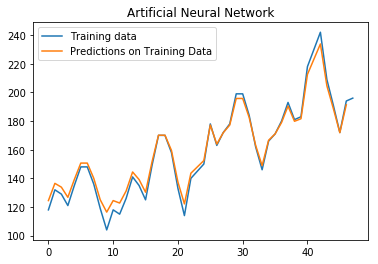

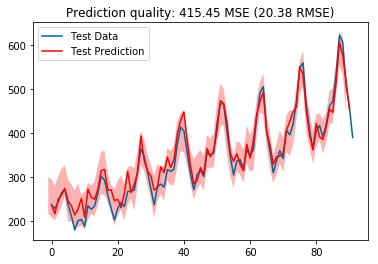

In [4]:
# generate predictions for training
uncertainty_samples = 1000

train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

print(test_predict.shape)

residuals = np.abs(y_test.reshape(-1, 1) - test_predict.reshape(-1, 1))

# Here we estimate the average residual 
sigma = 0.5*np.mean(residuals)
print("Estimated Sigma: ", sigma, np.std(residuals))




test_predictions = []
for k in range(0,uncertainty_samples):
    test_predict = model.predict(X_test)+np.random.normal(0.0, sigma, test_predict.shape)
    test_predictions.append(test_predict)

test_predictions = np.asarray(test_predictions)


# Unscale data
#test_predictions = scaler.inverse_transform(test_predictions)
y_train = invert_scaling(y_train,train_min,train_max)
train_predict = invert_scaling(train_predict,train_min,train_max)

# plot baseline and predictions
plt.plot(y_train, label='Training data');
plt.plot(train_predict[future:], label="Predictions on Training Data")
plt.legend(loc='best');
plt.title('Artificial Neural Network')
plt.show()




y = test_predict.flatten()[future:]

def return_min_max_prediction(test_predictions,i):
    
    y_vec = [ test_predictions[k][i][0] for k in range(0,test_predictions.shape[1])]
    
    ymin = np.min(y_vec)
    ymax = np.max(y_vec)
    
    return ymin,ymax


y_min = np.asarray([return_min_max_prediction(test_predictions,i)[0] for i in range(0,len(y))])
y_max = np.asarray([return_min_max_prediction(test_predictions,i)[1] for i in range(0,len(y))])
x = np.arange(-future,len(y_min)-future)


# Unscale all of the data
#print(y_test.shape)
y_test = invert_scaling(y_test,test_min,test_max)
y_min = invert_scaling(y_min,test_min,test_max)
y_max = invert_scaling(y_max,test_min,test_max)
y = invert_scaling(y,test_min,test_max)

# Compute the root mean squared error
mse = ((y_test[:-1].reshape(-1, 1) - y.reshape(-1, 1)) ** 2).mean()

plt.title('Prediction quality: {:.2f} MSE ({:.2f} RMSE)'.format(mse, math.sqrt(mse)))
plt.plot(y_test.reshape(-1, 1), label='Test Data', color='#006699')
plt.plot(y, label='Test Prediction', color='red')
plt.fill_between(x, y_min, y_max, facecolor='red', interpolate=True,alpha=0.3)
plt.legend(loc='best');
plt.show()